In [8]:
# setup the environment

import datetime as dt
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import pyxu.abc as pxa
import pyxu.operator as pxop
import pyxu.opt.stop as pxos
from pyxu.opt.solver.pgd import PGD

import pyfwl

seed = 1  # None  # for reproducibility
if seed is None:
    seed = np.random.randint(0, 1000)
print(f"Seed: {seed}")

Seed: 1


# Definition of the parameters of the problem

- Linear operator: $$ \mathbf{A} \in \mathbb{R}^{L\times N} $$

- Measurements: $$ \mathbf{y} \in \mathbb{R}^L $$

- Source signal: $$ \mathbf{x}_0 \in \mathbb{R}^N$$ with sparsity index $k$.

- LASSO problem:
\begin{equation}
    \min_\mathbf{x} \frac{1}{2} \lVert \mathbf{Ax} - \mathbf{y} \rVert_2^2 + \lambda \lVert \mathbf{x} \rVert_1
\end{equation}

---

In the following cell you can play with the parameters of the problem.

In [9]:
# Dimensions of the problem
L = 2000
N = 10000
k = 150
psnr = 20

# Parameter for reconstruction
lambda_factor = 0.1

## Parameters of the solvers
# Base
remove = True
min_iterations = 1
# Stop
eps = 1e-4
tmax = 15.0
eps_dcv = 1e-2
# PFW
ms_threshold = 0.8
init_correction = 1e-1
final_correction = 1e-6
correction_steps = 5

# Frank-Wolfe solvers

**Generation of the source**

In [10]:
rng = np.random.default_rng(seed)

# Source
indices = rng.choice(N, size=k)  # indices of active components in the source
injection = pxop.SubSample(N, indices).T
source = injection(rng.normal(size=k))  # sparse source

# Forward operator
mat = rng.normal(size=(L, N))  # explicit linear operator = matrix
op = pxa.LinOp.from_array(mat)
start = time.time()
lip = op.estimate_lipschitz(method='svd', tol=1.e-2)
print("Computation of the Lipschitz constant: {:.4f}".format(time.time()-start))

# Noisy measurements
noiseless_measurements = op(source)
std = np.max(np.abs(noiseless_measurements)) * 10 ** (-psnr / 20)
noise = rng.normal(0, std, size=L)
measurements = noiseless_measurements + noise

Computation of the Lipschitz constant: 4.1836


**Regularization parameter value**

In [11]:
lambda_ = lambda_factor * np.linalg.norm(op.T(measurements), np.infty)  # rule of thumb to define lambda

**Solvers**

In [12]:
vfw = pyfwl.VFWLasso(
    measurements,
    op,
    lambda_,
    step_size="optimal",
    show_progress=False
)

pfw = pyfwl.PFWLasso(
    measurements,
    op,
    lambda_,
    ms_threshold=ms_threshold,
    init_correction_prec=init_correction,
    final_correction_prec=final_correction,
    remove_positions=remove,
    min_correction_steps=correction_steps,
    show_progress=False,
)

**Stopping criteria**

In [13]:
stop_crit = pxos.RelError(
    eps=eps,
    var="objective_func",
    f=None,
    norm=2,
    satisfy_all=True,
)
# alternative stopping criteria
dcv = pyfwl.dcvStoppingCrit(eps_dcv)

# Minimum number of iterations
min_iter = pxos.MaxIter(n=min_iterations)

# Maximum duration
max_duration = pxos.MaxDuration(t=dt.timedelta(seconds=tmax))

stop = (min_iter & stop_crit) | max_duration

# track DCV
track_dcv = pxos.AbsError(eps=1e-10, var="dcv", f=None, norm=2, satisfy_all=True)

**Solving**

In [14]:
print("\nVanilla FW: Solving ...")
start = time.time()
vfw.fit(stop_crit= stop | track_dcv, diff_lipschitz=lip**2)
data_v, hist_v = vfw.stats()
time_v = time.time() - start
print("\tSolved in {:.3f} seconds".format(time_v))

print("Polyatomic FW: Solving ...")
start = time.time()
pfw.fit(stop_crit= stop | track_dcv, diff_lipschitz=lip**2)
data_p, hist_p = pfw.stats()
time_p = time.time() - start
print("\tSolved in {:.3f} seconds".format(time_p))



Vanilla FW: Solving ...
diff_lipschitz constant provided.
	Solved in 9.369 seconds
Polyatomic FW: Solving ...
diff_lipschitz constant provided.
	Solved in 3.060 seconds


**Comparison with APGD**

In [35]:
# Explicit definition of the objective function for APGD
data_fid = 0.5 * pxop.SquaredL2Norm(dim=op.shape[0]).argshift(-measurements) * op
regul = lambda_ * pxop.L1Norm(op.shape[1])

# Explicit definition of the objective function for APGD
data_fid = 0.5 * pxop.SquaredL2Norm(dim=op.shape[0]).argshift(-measurements) * op
# it seems necessary to manually lunch the evaluation of the diff lipschitz constant
data_fid.diff_lipschitz = lip ** 2
regul = lambda_ * pxop.L1Norm(N)

print("Solving with APGD: ...")
pgd = PGD(data_fid, regul, show_progress=False)
start = time.time()
pgd.fit(
    x0=np.zeros(N, dtype="float64"),
    stop_crit=(min_iter & pgd.default_stop_crit()) | pxos.MaxDuration(t=dt.timedelta(seconds=tmax)),
    track_objective=True,
    tau=1/lip**2
)
data_apgd, hist_apgd = pgd.stats()
time_pgd = time.time() - start
print("\tSolved in {:.3f} seconds".format(time_pgd))

Solving with APGD: ...
	Solved in 2.784 seconds


# Evaluation of the solvers

In [36]:
print("Final value of dual certificate:\n\tVFW: {:.4f}\n\tPFW: {:.4f}\n\tAPGD: {:.4f}\n".format(
    data_v["dcv"], data_p["dcv"], np.abs(data_fid.grad(data_apgd["x"])).max()/lambda_))
print(
    "Final value of objective function:\n\tVFW : {:.2f}\n\tPFW : {:.2f}\n\tAPGD: {:.2f}".format(
        hist_v[-1][-1], hist_p[-1][-1], hist_apgd[-1][-1]))

Final value of dual certificate:
	VFW: -1.2998
	PFW: -1.0509
	APGD: 1.0023

Final value of objective function:
	VFW : 75596.67
	PFW : 75187.34
	APGD: 75183.13


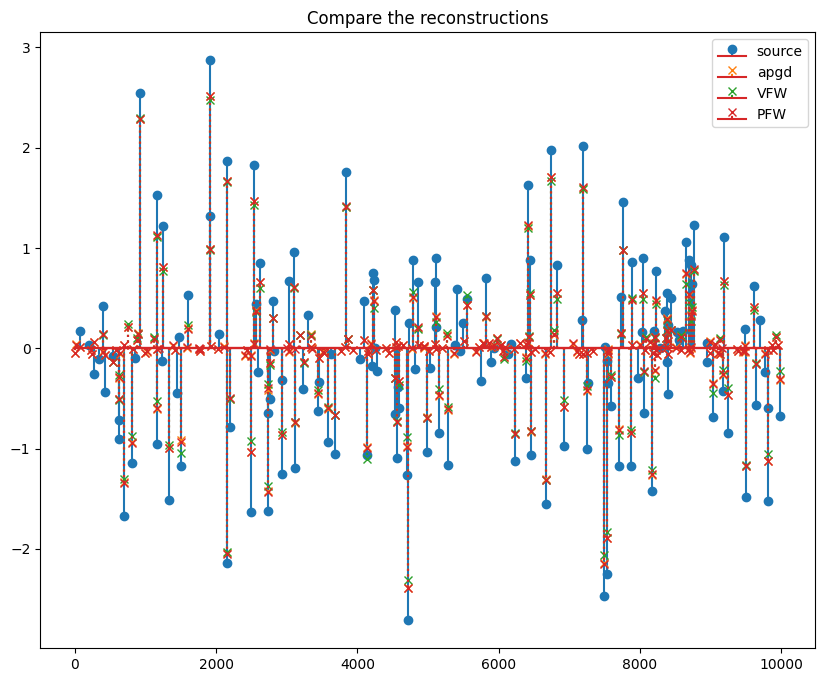

In [37]:
def supp(arr):
    return np.where(np.abs(arr) > 1e-3)[0]

plt.figure(figsize=(10, 8))
plt.title("Compare the reconstructions")
plt.stem(supp(source), source[supp(source)], label="source", linefmt="C0-", markerfmt="C0o")
plt.stem(supp(data_apgd["x"]), data_apgd["x"][supp(data_apgd["x"])], label="apgd", linefmt="C1:", markerfmt="C1x")
plt.stem(supp(data_v["x"]), data_v["x"][supp(data_v["x"])], label="VFW", linefmt="C2:", markerfmt="C2x")
plt.stem(supp(data_p["x"]), data_p["x"][supp(data_p["x"])],label="PFW", linefmt="C3:", markerfmt="C3x")
plt.legend()
plt.show()

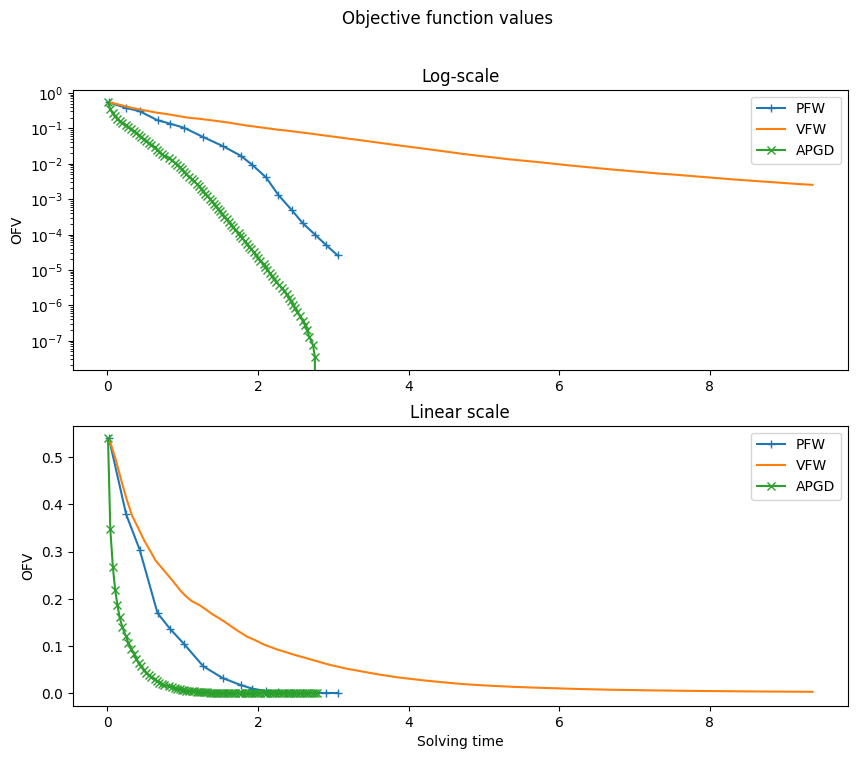

In [38]:
mini = min(
    hist_p["Memorize[objective_func]"][-1],
    hist_v["Memorize[objective_func]"][-1],
    hist_apgd["Memorize[objective_func]"][-1],
)

plt.figure(figsize=(10, 8))
plt.suptitle("Objective function values")
plt.subplot(211)
plt.title("Log-scale")
plt.yscale("log")
plt.plot(
    hist_p["duration"],
    (hist_p["Memorize[objective_func]"] - mini) / (hist_apgd["Memorize[objective_func]"][0]),
    label="PFW",
    marker="+",
)
plt.plot(
    hist_v["duration"],
    (hist_v["Memorize[objective_func]"] - mini) / (hist_apgd["Memorize[objective_func]"][0]),
    label="VFW",
)
plt.plot(
    hist_apgd["duration"],
    (hist_apgd["Memorize[objective_func]"] - mini) / (hist_apgd["Memorize[objective_func]"][0]),
    label="APGD",
    marker="x",
)
plt.legend()
plt.ylabel("OFV")

plt.subplot(212)
plt.plot(
    hist_p["duration"],
    (hist_p["Memorize[objective_func]"] - mini) / (hist_apgd["Memorize[objective_func]"][0]),
    label="PFW",
    marker="+",
)
plt.plot(
    hist_v["duration"],
    (hist_v["Memorize[objective_func]"] - mini) / (hist_apgd["Memorize[objective_func]"][0]),
    label="VFW",
)
plt.plot(
    hist_apgd["duration"],
    (hist_apgd["Memorize[objective_func]"] - mini) / (hist_apgd["Memorize[objective_func]"][0]),
    label="APGD",
    marker="x",
)
plt.legend()
plt.ylabel("OFV")
plt.xlabel("Solving time")
plt.title("Linear scale")
plt.show()


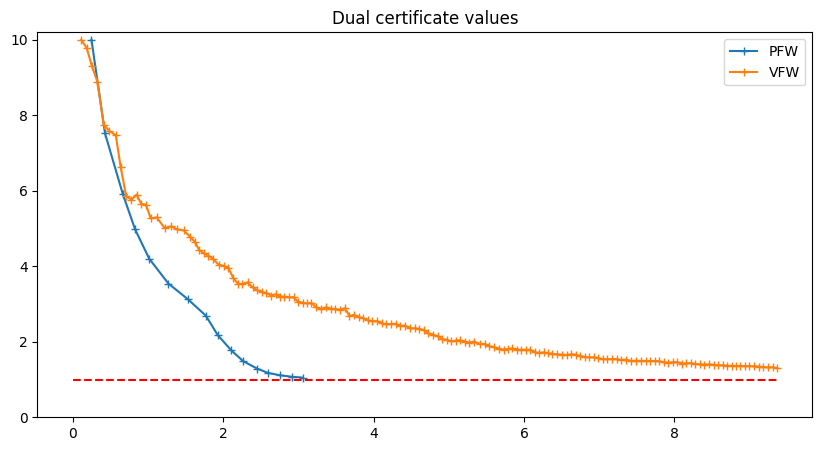

In [39]:
plt.figure(figsize=(10, 5))
plt.title("Dual certificate values")
plt.plot(hist_p["duration"], hist_p["AbsError[dcv]"], label="PFW", marker="+")
plt.plot(hist_v["duration"], hist_v["AbsError[dcv]"], label="VFW", marker="+")
plt.legend()
plt.hlines(1, 0, hist_v["duration"].max(), color='r', ls="--")
plt.ylim(0, 1.02/lambda_factor)
plt.show()

# Influence of the parameters of Polyatomic Frank-Wolfe

In [40]:
def plot_comparison(l, key, solvers, hs):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    plt.figure(figsize=(12, 8))
    plt.suptitle("Performance analysis of PFW: " + key)
    plt.subplot(211)
    mini = min([h['Memorize[objective_func]'][-1] for h in hs])
    for i, h in enumerate(hs):
        plt.plot(
        h["duration"],
        (h["Memorize[objective_func]"] - mini) / (h["Memorize[objective_func]"][0]),
        label=l[i],
        marker="+",
        color=colors[i])
    plt.legend()
    plt.title("Objecive function value")
    for i, solver in enumerate(solvers):
        mst = solver._mstate
        plt.subplot(4, 3,7+i)
        plt.plot(mst["N_indices"], label="Support size", marker="o", alpha=.5, c=colors[i])
        plt.plot(mst["N_candidates"], label="Candidates", marker="s", alpha=.5, c=colors[i])
        plt.legend()
        plt.title("Candidates and support")

        plt.subplot(4, 3,10+i)
        plt.plot(mst["correction_iterations"], label="iterations", marker="o", alpha=.5, c=colors[i])
        plt.ylim(bottom=0.)
        plt.twinx()
        plt.plot(mst["correction_durations"], label="duration", marker="x", alpha=.5, c=colors[i])
        plt.ylim(bottom=0.)
        plt.title("Correction iterations")
        plt.legend()

    plt.show()

## Multi spikes threshold

In [41]:
key = "ms_threshold"
l = [.7, .8, .9]

Polyatomic FW: Solving for ms_threshold = 0.7
diff_lipschitz constant provided.
	Solved in 2.777 seconds
Polyatomic FW: Solving for ms_threshold = 0.8
diff_lipschitz constant provided.
	Solved in 3.574 seconds
Polyatomic FW: Solving for ms_threshold = 0.9
diff_lipschitz constant provided.
	Solved in 7.954 seconds


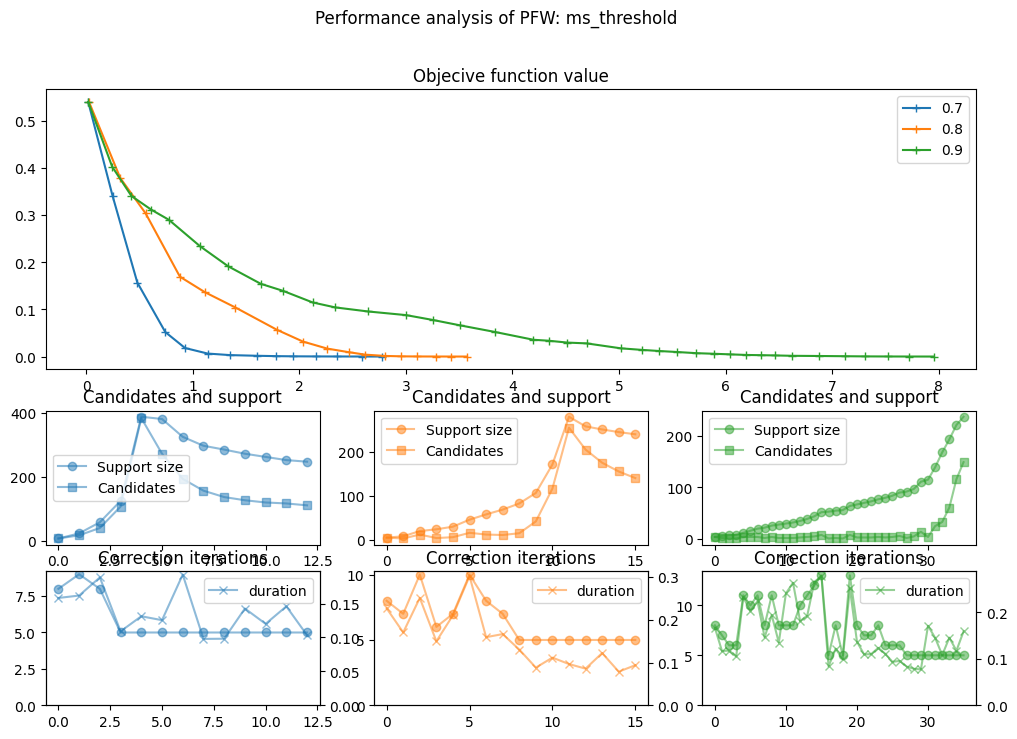

In [42]:
# ms_threshold
# init_correction_prec
# correction_steps

solvers = []
ds = []
hs = []
for elem in l:
    solver = pyfwl.PFWLasso(
        measurements,
        op,
        lambda_,
        ms_threshold=elem,
        init_correction_prec=init_correction,
        final_correction_prec=final_correction,
        remove_positions=remove,
        min_correction_steps=correction_steps,
        show_progress=False,
    )
    solvers.append(solver)
    
    print("Polyatomic FW: Solving for " + key + " = {}".format(elem))
    solver.fit(stop_crit= stop | track_dcv, diff_lipschitz=lip**2)
    d, h = solver.stats()
    print("\tSolved in {:.3f} seconds".format(h["duration"][-1]))
    ds.append(d)
    hs.append(h)
    
plot_comparison(l, key, solvers, hs)


## Initial correction precision

In [43]:
key = "init_correction_prec"
l = [1e-1, 5e-2, 1e-2]

Polyatomic FW: Solving for init_correction_prec = 0.1
diff_lipschitz constant provided.
	Solved in 3.316 seconds
Polyatomic FW: Solving for init_correction_prec = 0.05
diff_lipschitz constant provided.
	Solved in 3.953 seconds
Polyatomic FW: Solving for init_correction_prec = 0.01
diff_lipschitz constant provided.
	Solved in 8.264 seconds


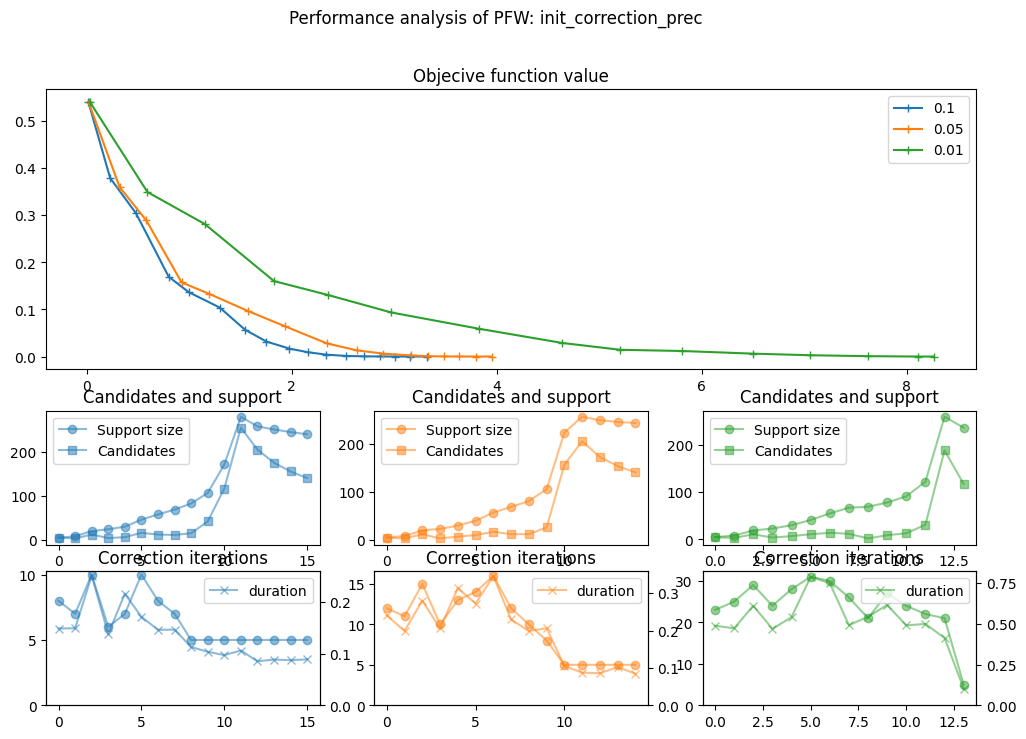

In [44]:
solvers = []
ds = []
hs = []
for elem in l:
    solver = pyfwl.PFWLasso(
        measurements,
        op,
        lambda_,
        ms_threshold=.8,
        init_correction_prec=elem,
        final_correction_prec=final_correction,
        remove_positions=remove,
        min_correction_steps=correction_steps,
        show_progress=False,
    )
    solvers.append(solver)
    
    print("Polyatomic FW: Solving for " + key + " = {}".format(elem))
    solver.fit(stop_crit= stop | track_dcv, diff_lipschitz=lip**2)
    d, h = solver.stats()
    print("\tSolved in {:.3f} seconds".format(h["duration"][-1]))
    ds.append(d)
    hs.append(h)
    
plot_comparison(l, key, solvers, hs)

Polyatomic FW: Solving for init_correction_prec = 0.1
diff_lipschitz constant provided.
	Solved in 4.708 seconds
Polyatomic FW: Solving for init_correction_prec = 0.05
diff_lipschitz constant provided.
	Solved in 3.649 seconds
Polyatomic FW: Solving for init_correction_prec = 0.01
diff_lipschitz constant provided.
	Solved in 3.141 seconds


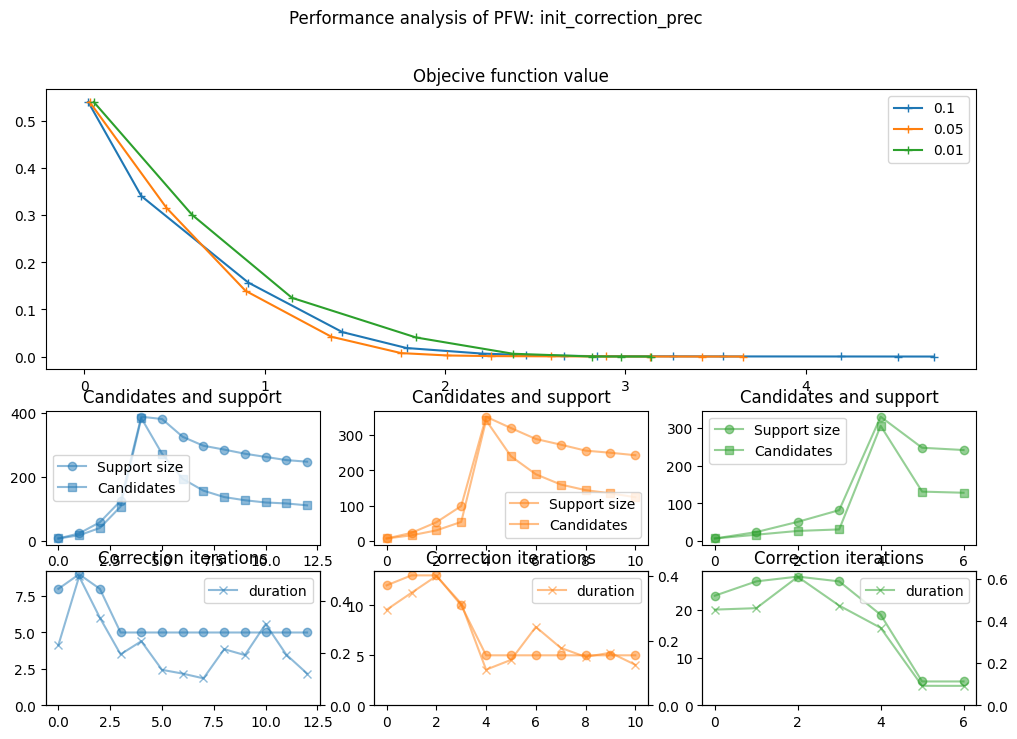

In [45]:
solvers = []
ds = []
hs = []
for elem in l:
    solver = pyfwl.PFWLasso(
        measurements,
        op,
        lambda_,
        ms_threshold=.7,
        init_correction_prec=elem,
        final_correction_prec=final_correction,
        remove_positions=remove,
        min_correction_steps=correction_steps,
        show_progress=False,
    )
    solvers.append(solver)
    
    print("Polyatomic FW: Solving for " + key + " = {}".format(elem))
    solver.fit(stop_crit= stop | track_dcv, diff_lipschitz=lip**2)
    d, h = solver.stats()
    print("\tSolved in {:.3f} seconds".format(h["duration"][-1]))
    ds.append(d)
    hs.append(h)
    
plot_comparison(l, key, solvers, hs)

## Minimum number of reweighting steps

In [46]:
key = "correction_steps"
l = [2, 5, 15]

Polyatomic FW: Solving for correction_steps = 2
diff_lipschitz constant provided.
	Solved in 4.067 seconds
Polyatomic FW: Solving for correction_steps = 5
diff_lipschitz constant provided.
	Solved in 3.048 seconds
Polyatomic FW: Solving for correction_steps = 15
diff_lipschitz constant provided.
	Solved in 2.592 seconds


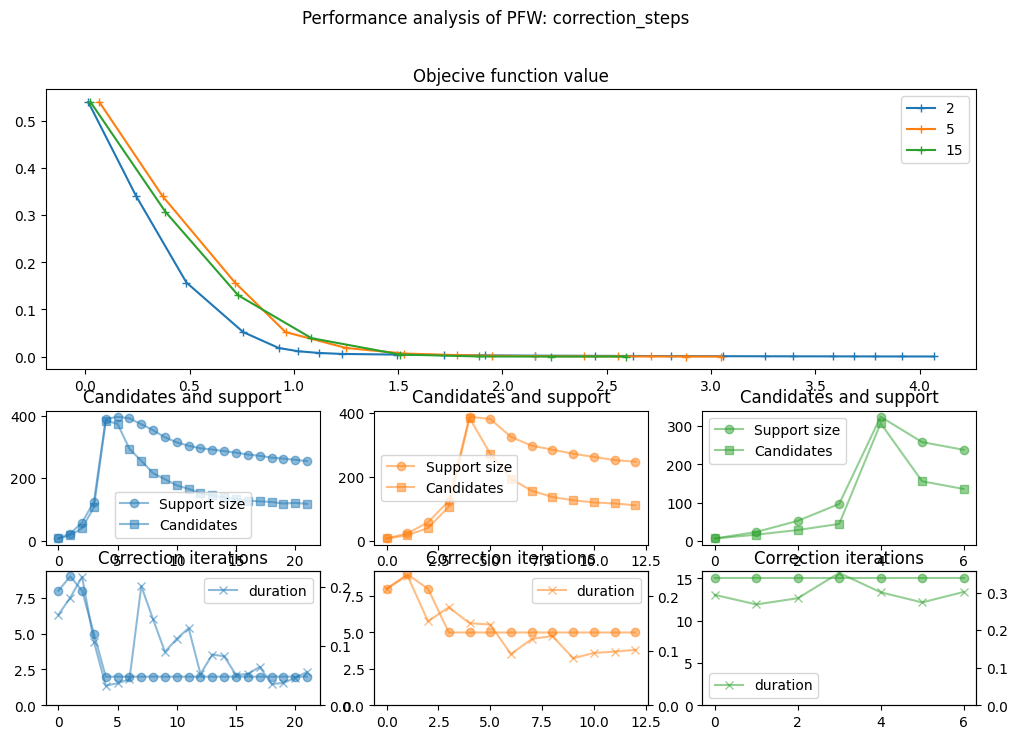

In [47]:
solvers = []
ds = []
hs = []
for elem in l:
    solver = pyfwl.PFWLasso(
        measurements,
        op,
        lambda_,
        ms_threshold=.7,
        init_correction_prec=.1,
        final_correction_prec=final_correction,
        remove_positions=remove,
        min_correction_steps=elem,
        show_progress=False,
    )
    solvers.append(solver)
    
    print("Polyatomic FW: Solving for " + key + " = {}".format(elem))
    solver.fit(stop_crit= stop | track_dcv, diff_lipschitz=lip**2)
    d, h = solver.stats()
    print("\tSolved in {:.3f} seconds".format(h["duration"][-1]))
    ds.append(d)
    hs.append(h)
    
plot_comparison(l, key, solvers, hs)

## Fixed number of reweighting steps

In [48]:
key = "correction_steps"
l = [2, 5, 15]

Polyatomic FW: Solving for correction_steps = 2
diff_lipschitz constant provided.
	Solved in 3.250 seconds
Polyatomic FW: Solving for correction_steps = 5
diff_lipschitz constant provided.
	Solved in 3.057 seconds
Polyatomic FW: Solving for correction_steps = 15
diff_lipschitz constant provided.
	Solved in 2.475 seconds


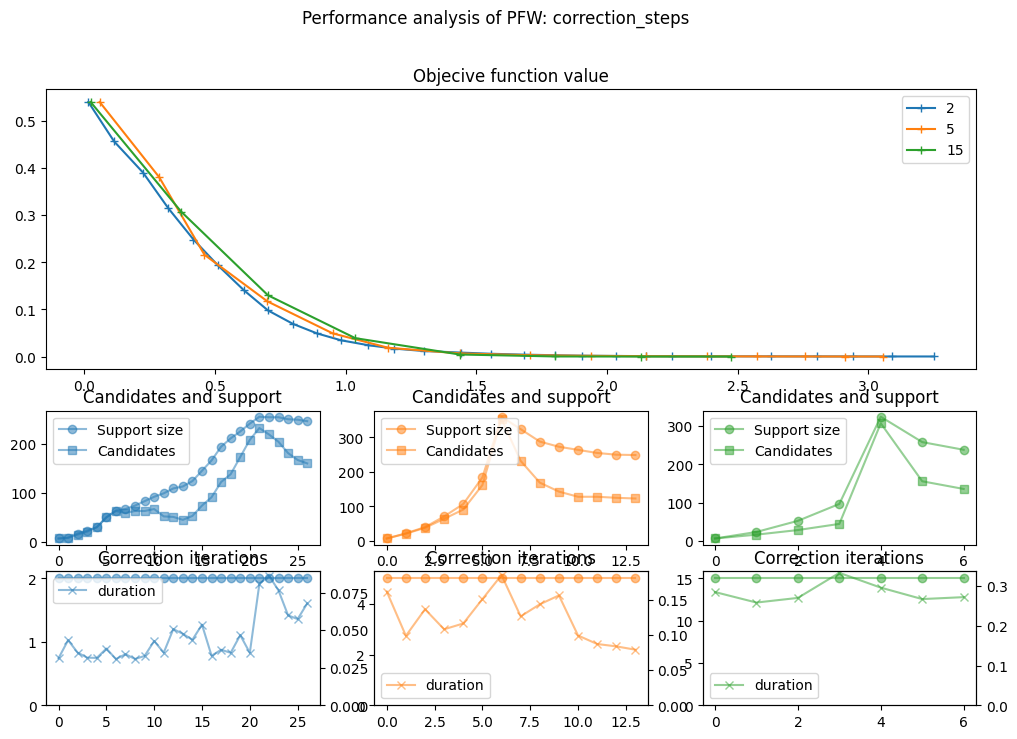

In [49]:
solvers = []
ds = []
hs = []
for elem in l:
    solver = pyfwl.PFWLasso(
        measurements,
        op,
        lambda_,
        ms_threshold=.7,
        init_correction_prec=.1,
        final_correction_prec=final_correction,
        remove_positions=remove,
        min_correction_steps=elem,
        show_progress=False,
    )
    solvers.append(solver)
    
    print("Polyatomic FW: Solving for " + key + " = {}".format(elem))
    solver.fit(stop_crit= stop | track_dcv, lock_reweighting=True, diff_lipschitz=lip**2)
    d, h = solver.stats()
    print("\tSolved in {:.3f} seconds".format(h["duration"][-1]))
    ds.append(d)
    hs.append(h)
    
plot_comparison(l, key, solvers, hs)